## Overview

Similar to Pandas, GeoPandas has a `plot()` method that can plot geospatial data using Matplotlib.

We will work with census data to create a choropleth map of population density. We will start with a shapefile of census tracts, and join it with tabular data to get a GeoDataframe with census tract geometry and correponding populations.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip install mapclassify

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
      with requests.get(url, stream=True, allow_redirects=True) as r:
          with open(filename, 'wb') as f:
              for chunk in r.iter_content(chunk_size=8192):
                  f.write(chunk)
      print('Downloaded', filename)

We will download the the census tracts shapefile and a CSV file containing a variety of population statistics for each tract.

In [ ]:
shapefile_name = 'tl_2019_06_tract'
shapefile_exts = ['.shp', '.shx', '.dbf', '.prj']
data_url = 'https://github.com/spatialthoughts/python-dataviz-web/releases/' \
  'download/census/'

for ext in shapefile_exts:
  url = data_url + shapefile_name + ext
  download(url)

csv_name = 'ACSST5Y2019.S0101_data.csv'
download(data_url + csv_name)


## Data Pre-Processing

Let's read the census tracts shapefile and the CSV file containing population counts.

In [ ]:
shapefile_path = os.path.join(data_folder, shapefile_name + '.shp')
tracts = gpd.read_file(shapefile_path)
tracts

We now read the file containing a variety of population statistics for each tract. We read this file as a Pandas DataFrame. The CSV file contains an extra row before the header, so we specify `skiprows=[1]` to skip reading it.

In [ ]:
csv_path = os.path.join(data_folder, csv_name)
table = pd.read_csv(csv_path, skiprows=[1])
table

To join this DataFrame with the GeoDataFrame, we need a column with unique identifiers. We use the `GEOID` column and process the id so they match exactly in both datasets.

In [ ]:
filtered = table[['GEO_ID','NAME', 'S0101_C01_001E']]
filtered = filtered.rename(columns = {'S0101_C01_001E': 'Population', 'GEO_ID': 'GEOID'})

filtered['GEOID'] = filtered.GEOID.str[-11:]

Finally, we do a table join using the `merge` method.

In [ ]:
gdf = tracts.merge(filtered, on='GEOID')
gdf

For creating a choropleth map, we must normalize the population counts. US Census Bureau [recommends](https://www.census.gov/quickfacts/fact/note/US/LND110210) calculating the population density by dividing the total population by the land area. The original shapefile contains a column `ALAND` with the land area in square kilometers. Using it, we compute a new column `density` containing the persons per square kilometer.

In [ ]:
gdf['density'] = 1e6*gdf['Population']/gdf['ALAND']
gdf

## Create a Choropleth Map

The `plot()` method will render the data to a plot.

Reference: [geopandas.GeoDataFrame.plot](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html)

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
gdf.plot(ax=ax)
plt.show()

You can supply additional style options to change the appearance of the map. `facecolor` and `edgecolor` parameters are used to determine the fill and outline colors respectively. The stroke width can be adjusted using the `linewidth` parameter.

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
gdf.plot(ax=ax, facecolor='#f0f0f0', edgecolor='#de2d26', linewidth=0.5)

plt.show()

We have the population density for each tract in the `density` column. We can assign a color to each polygon based on the value in this column - resulting in a choropleth map. Additionally, we need to specify a color ramp using `cmap` and classification scheme using `scheme`. The classification schedule will determine how the continuous data will be classified into discrete bins.

> Tip: You can add `_r` to any color ramp name to get a **r**eversed version of that ramp.

References:
- [Matplotlib Colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
- [Mapclassify Classification Schemes](https://pysal.org/mapclassify/generated/mapclassify.classify.html#mapclassify.classify)

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
gdf.plot(ax=ax, column='density', cmap='RdYlGn_r', scheme='quantiles')
plt.show()

Instead of the class breaks being determined by the classification scheme, we can also manually specify the ranges. This is preferable so we can have a human-interpretable legend. The `legend=True` parameter adds a legend to our plot.

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)

classification_kwds={
  'bins': [1,10,25,50,100, 250, 500, 1000, 5000]
}
gdf.plot(ax=ax, column='density', cmap='RdYlGn_r', scheme='User_Defined',
         classification_kwds=classification_kwds, legend=True)

plt.show()

We can supply legend customization options via the `legend_kwds` parameter and adjust the legend position, formatting of the text, and add a legend title. We can also manually adjust the legend entries, to give a more legible labels.



In [ ]:
legend_kwds= {
  'loc': 'upper right',
  'bbox_to_anchor': (0.8, 0.9),
  'fmt': '{:<5.0f}',
  'frameon': False,
  'fontsize': 8,
  'title': 'persons/sq.km.'
}
classification_kwds={
  'bins':[1,10,25,50,100, 250, 500, 1000, 5000]
}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
gdf.plot(ax=ax, column='density', cmap='RdYlGn_r', scheme='User_Defined',
         classification_kwds=classification_kwds,
         legend=True, legend_kwds=legend_kwds)

ax.set_axis_off()

# Change the last entry in the legend to '>5000'
legend = ax.get_legend()
legend.texts[-1].set_text('> 5000')

plt.show()

Once we are happy with the look, we add a title and save the result as a PNG file. Remember to call `plt.savefig()` before showing the plot as the plot gets emptied after being shown.

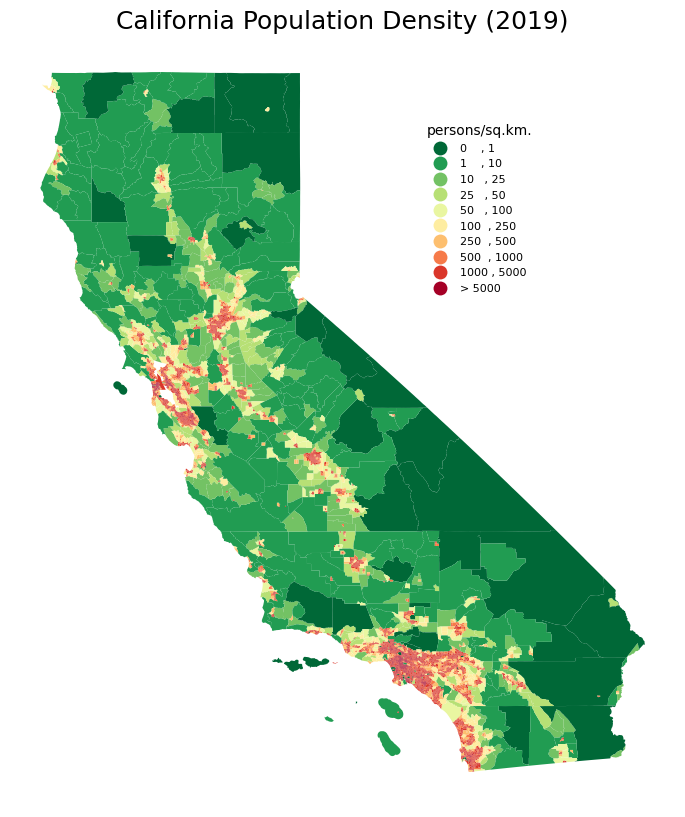

In [33]:
legend_kwds= {
  'loc': 'upper right',
  'bbox_to_anchor': (0.8, 0.9),
  'fmt': '{:<5.0f}',
  'frameon': False,
  'fontsize': 8,
  'title': 'persons/sq.km.'
}
classification_kwds={
  'bins':[1,10,25,50,100, 250, 500, 1000, 5000]
}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
gdf.plot(ax=ax, column='density', cmap='RdYlGn_r', scheme='User_Defined',
         classification_kwds=classification_kwds,
         legend=True, legend_kwds=legend_kwds)

ax.set_axis_off()

# Change the last entry in the legend to '>5000'
legend = ax.get_legend()
legend.texts[-1].set_text('> 5000')

# Add a title
ax.set_title('California Population Density (2019)', size = 18)

output_path = os.path.join(output_folder, 'california_pop.png')
plt.savefig(output_path, dpi=300)

plt.show()

## Exercise

1. Plot the census tracts geodataframe `tracts` with just outlines and no fill color.
2. Display the plot zoomed-in around the San Francisco area between Latitudes from `37.71` to `37.82` and Longitudes from `-122.53` to `-122.36`.

Hints

* Set the `facecolor` option to `'none'` for no fills. Check the [*style_kwds* parameter](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html) of the `plot()` method for more details.
* Use the `set_xlim()` and `set_ylim()` methods to set the view area of the Axes.

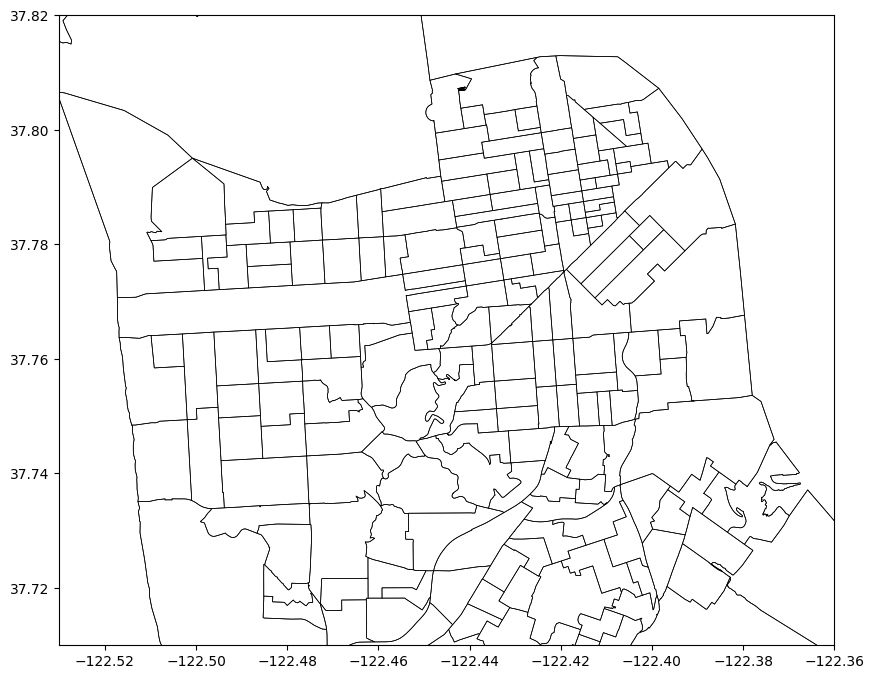

In [32]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
ax.set_xlim(-122.53, -122.36)
ax.set_ylim(37.71, 37.82)
tracts.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
plt.show()